### Two State least squares fitting for mitoTotal and mitoRibo kinetic rate estimates

- Author: Robert Ietswaart and Gyan Prakash
- date: 20221122
- License: BSD2.  
- Python v3.7.4 
 
- For Erik's mitoRNA project

In [119]:
import os
import pandas as pd
import numpy as np
from lmfit import minimize, Parameters, fit_report
import matplotlib.pyplot as plt
import seaborn as sns
import new_total_ratio as ntr
import fit
import aic

In [120]:
time_all = pd.Series([0,15,30,60])#unit: min
k_bound_lo = 1e-4 #unit: min^-1: 1 per 7 days
k_bound_hi = 1e4 #unit: min^-1: 1 per 6 ms

# loads the csv and removes the NaN values 
path = os.path.join('/n','groups','churchman','ri23','RNAdecay','MitoRibo20221122')
TC_MAP_IP = pd.read_csv(os.path.join(path, "TL11_IP_MTdsrRNA_t5MMinformed4_modeAll_PcBin1_2_3_4.tsv"),
                        sep='\t',header=(0)).dropna()
TC_MAP = pd.read_csv(os.path.join(path,  "TL11_tot_MTdsrRNA_t5MMinformed4_modeAll_PcBin1_2_3_4.tsv"),
                     sep='\t',header=(0)).dropna()
genes_with_data = set(TC_MAP.Symbol).intersection(TC_MAP_IP.Symbol)

#list(TC_MAP_IP.columns.values) 
# TC_MAP_IP = pd.read_csv( "TL9_IP_MTdsrRNA_t5MTMMinformed6_modeAll_PcBruteBinCombo.tsv" ,sep='\t',header=(0)).dropna()
# TC_MAP = pd.read_csv( "TL9_tot_MTdsrRNA_t5MTMMinformed6_modeAll_PcBruteBinCombo.tsv" ,sep='\t',header=(0)).dropna()
#different time-points at which the 4sU labelling has been performed. 

In [121]:
# TC_MAP_IP

In [122]:
# TC_MAP

In [142]:
def final_outcome(data_input_total, data_input_ribo, gene):
    #Two state model with 1 degradation rate: Kd (for state A and B)
    params = Parameters()
    params.add('degradation', value=0.001, min=k_bound_lo,max=k_bound_hi) #min=0, max=np.inf)
    params.add('transitionAB', value=0.005, min=k_bound_lo, max=k_bound_hi)
    
    out1 = minimize(fit.res_2models, params, method='ampgo',
                    args=(time_all, ntr.lam1state_total, ntr.lam_ribo_1deg, 
                          data_input_total, data_input_ribo),
                    nan_policy='omit')
    res1 = out1.residual
    report1 = fit_report(out1)
    
    out1Arr=[out1.params['degradation'].value,
             out1.params['transitionAB'].value]
    
    
    #Two state model with state-dependent degradation rates
    params = Parameters()
    params.add('degradationA', value=0.001, min=k_bound_lo,max=k_bound_hi) #min=0, max=np.inf)
    params.add('transitionAB', value=0.005, min=k_bound_lo, max=k_bound_hi)
    params.add('degradationB', value=0.0005, min=k_bound_lo, max=k_bound_hi)
    
    out2 = minimize(fit.res_2models, params, method='ampgo',
                    args=(time_all, ntr.lam2state_total, ntr.lam2state_ribo, 
                          data_input_total, data_input_ribo),
                    nan_policy='omit')
    res2 = out2.residual
    report2 = fit_report(out2)
    
    out2Arr=[out2.params['degradationA'].value,
             out2.params['transitionAB'].value,
             out2.params['degradationB'].value]
    
    out3 = aic.calc_aic(out1.ndata,out1.chisqr,out2.chisqr,out1.nvarys,out2.nvarys)
    
    out4 = aic.calc_aic_nocr(out1.ndata,out1.chisqr,out2.chisqr,out1.nvarys,out2.nvarys)
     
    table_outcomes = {
      'Gene': gene,
      'Model1_kD': out1Arr[0],
      'Model1_kAB': out1Arr[1],
      'Model2_kA': out2Arr[0],
      'Model2_kAB': out2Arr[1],
      'Model2_kB': out2Arr[2], 
      'AIC_pmodel1': out3[0],#used in McShane et al 2016
      'AIC_pmodel2': out3[1],
      'AICnc_pmodel1': out4[0],#No low data Correction: less conservative
      'AICnc_pmodel2': out4[1],         
      "RSS_model1": np.sum(np.asarray(res1)**2),
      "RSS_model2": np.sum(np.asarray(res2)**2)}
    
    plot_outcomes = {
      'Gene': gene,
      'Model1 (kD, kAB)': out1Arr,
      'Model2 (kA, kAB, kB)': out2Arr, 
      'AIC (model1 vs model2)': out3,
      'AICnc (model1 vs model2)': out4,  
      'residuals_model1': res1,
      'residuals_model2': res2,
      'report1': report1,
      'report2': report2}
    
    return table_outcomes, plot_outcomes

In [143]:
# here we are defining a function, which loops over different time points to provide MAP value for a gene. Then we pass 
#the output of the data to the final_outcome function to return a dataframe with all the genes. 

def get_output_data(gene):
    col_tot=[]
    data_tot=[]
    col_IP=[]
    data_IP=[]    
    Gene_Name=gene        

    for t in time_all:
        a=TC_MAP[TC_MAP.Symbol == Gene_Name].index[0]
        col_tot=TC_MAP['TL11_'+str(t)+'m'+' '+'MAP']
        data_tot.append(col_tot[a])
        
        a=TC_MAP_IP[TC_MAP_IP.Symbol == Gene_Name].index[0]
        col_IP=TC_MAP_IP['TL11_'+str(t)+'m'+' '+'MAP']
        data_IP.append(col_IP[a])
        
    data_tot = pd.Series(data_tot)
    data_IP = pd.Series(data_IP)
    return final_outcome(data_tot, data_IP, gene)

### Output to file

In [144]:
output_all = []
for symbol in genes_with_data:
    print(symbol)
    output_gene , _ = get_output_data(symbol)
    output_all.append(output_gene)
    
final_df = pd.DataFrame(output_all)

MT-ND3
MT-ATP8-6
MT-TS1
MT-antiND5
MT-TF
MT-antiND3
MT-antiND1
MT-antiCYB
7S
MT-CO2
MT-ND6
MT-TH
MT-CYB
MT-TA
MT-antiATP8-6-CO3
MT-TK
MT-ND4L-4
MT-TQ
MT-RNR2
MT-antiND2
MT-antiCO2
MT-antiCO1
MT-ND1
MT-CO1
MT-TE
MT-RNR1
MT-TY
MT-ND2
MT-TV
MT-antiND4L-4
MT-TM
MT-CO3
MT-TC
MT-TS2
MT-TT
MT-ND5


In [155]:
filename = 'Fit_all_rates_20221122_twostate.tsv'
final_df.to_csv(os.path.join(path, filename), sep='\t',index=False)

In [146]:
final_df

,Gene,Model1_kD,Model1_kAB,Model2_kA,Model2_kAB,Model2_kB,AIC_pmodel1,AIC_pmodel2,AICnc_pmodel1,AICnc_pmodel2,RSS_model1,RSS_model2
0,MT-ND3,0.017515,0.075470,0.017402,0.000117,0.092959,0.942838,0.057162,0.731648,0.268352,0.011772,0.011781
1,MT-ATP8-6,0.004706,0.090391,0.004607,0.000100,0.095101,0.942821,0.057179,0.731589,0.268411,0.002332,0.002334
2,MT-TS1,0.002155,0.000100,0.002276,0.000100,0.001063,0.941621,0.058379,0.727236,0.272764,0.006876,0.006843
3,MT-antiND5,0.011269,9988.479577,0.006111,0.005161,3284.775510,0.942677,0.057323,0.731062,0.268938,0.054230,0.054230
4,MT-TF,0.002158,0.000100,0.002313,0.000100,0.000922,0.940950,0.059050,0.724820,0.275180,0.005117,0.005077
5,MT-antiND3,0.013459,328.256860,0.010499,0.002964,9700.080671,0.942666,0.057334,0.731022,0.268978,0.200604,0.200595
6,MT-antiND1,0.013513,166.555785,8811.709570,7417.478945,0.013512,0.942672,0.057328,0.731044,0.268956,0.245751,0.245747
7,MT-antiCYB,8094.191873,278.618359,9999.935050,3618.684407,4058.591941,0.942676,0.057324,0.731059,0.268941,1.494051,1.494051
8,7S,0.005644,0.305634,0.004816,0.000829,0.311948,0.942735,0.057265,0.731272,0.268728,0.004169,0.004170
9,MT-CO2,0.005529,0.096377,0.003145,0.002413,0.100126,0.941548,0.058452,0.726975,0.273025,0.001505,0.001497


## Plotting

In [148]:
def data_plt_total(gene):

    col_tot=[]
    data_tot=[]
    Gene_Name=gene

    for t in time_all:
        a=TC_MAP[TC_MAP.Symbol == Gene_Name].index[0]
        col_tot=TC_MAP['TL11_'+str(t)+'m'+' '+'MAP']
        data_tot.append(col_tot[a])

    return np.asarray(data_tot)

In [149]:
def data_plt_IP(gene):

    col_IP=[]
    data_IP=[]    
    Gene_Name=gene        

    for t in time_all:
        a=TC_MAP_IP[TC_MAP_IP.Symbol == Gene_Name].index[0]
        col_IP=TC_MAP_IP['TL11_'+str(t)+'m'+' '+'MAP']
        data_IP.append(col_IP[a])

    return np.asarray(data_IP)

In [150]:
def plot_model (gene_name):
    
    x = time_all
    y_total = data_plt_total(gene_name)
    y_ribo = data_plt_IP(gene_name)
    _ , plot_outcomes = get_output_data(gene_name)
    y_model1_total = plot_outcomes['residuals_model1'][:4] + y_total
    y_model1_ribo = plot_outcomes['residuals_model1'][4:] + y_ribo
    y_model2_total = plot_outcomes['residuals_model2'][:4] + y_total
    y_model2_ribo = plot_outcomes['residuals_model2'][4:] + y_ribo

    plt.plot(x, y_total, 'bo', label= gene_name+'Total')
    plt.plot(x, y_ribo, 'bs', label= gene_name+'Mito_Ribo')    
    plt.plot(x, y_model1_total, 'r--', label='Model1 Total')
    plt.plot(x, y_model1_ribo, 'g--', label='Model1 Ribo')    
    plt.plot(x, y_model2_total, 'r:', label='Model2 Total')
    plt.plot(x, y_model2_ribo, 'g:', label='Model2 Ribo') 
    plt.legend(loc='best')
    plt.xlabel('Time (mins)')
    plt.ylabel('fraction 4sU labeled') 
    
    return plt.show()

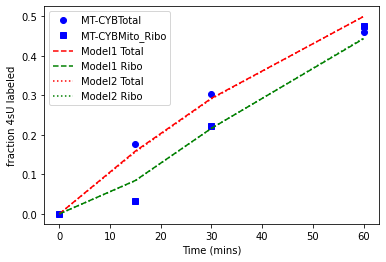

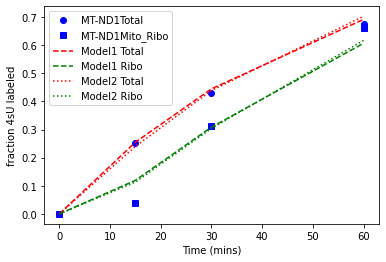

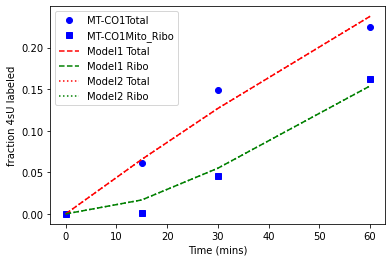

In [151]:
plot_model('MT-CYB')
plot_model('MT-ND1')
plot_model('MT-CO1')

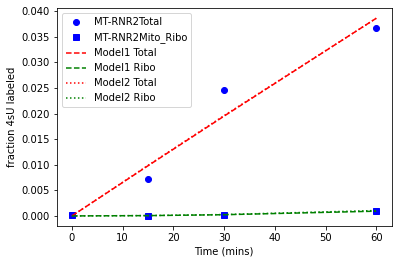

In [157]:
plot_model('MT-RNR2')

# Scraps below

In [ ]:
#, columns=["Gene", 
#                                              "Fit1 (Kd,Kab)",
#                                              "Fit2 (Ka, Kab, Kb)",
#                                              "AIC (model1 vs model2)",
#                                              "AIC no low data correction",
#                                              "Residual model1",
#                                              "Residual model2",
#                                              "Fit report model1",
#                                              "Fit report model2"])

In [152]:
symbol = 'MT-ND1'
_ , plot_outcomes = get_output_data(symbol)
plot_outcomes

{'Gene': 'MT-ND1',
 'Model1 (kD, kAB)': [0.01959943995645482, 0.0702482718003638],
 'Model2 (kA, kAB, kB)': [0.00010000372202265285,
  0.021605199871206113,
  0.0722906781173278],
 'AIC (model1 vs model2)': [0.9026397609410353, 0.09736023905896472],
 'AICnc (model1 vs model2)': [0.6051345208149862, 0.39486547918501386],
 'residuals_model1': array([-0.0006    ,  0.00101725,  0.01505362,  0.01767932, -0.0007    ,
         0.08037561, -0.00578092, -0.052727  ]),
 'residuals_model2': array([-0.0006    , -0.01372138,  0.00886252,  0.02874307, -0.0007    ,
         0.07422709, -0.01032901, -0.04236213]),
 'report1': '[[Fit Statistics]]\n    # fitting method   = ampgo, with L-BFGS-B as local solver\n    # function evals   = 528\n    # data points      = 8\n    # variables        = 2\n    chi-square         = 0.00981485\n    reduced chi-square = 0.00163581\n    Akaike info crit   = -49.6264025\n    Bayesian info crit = -49.4675194\n##  Warning: uncertainties could not be estimated:\n    this f

In [153]:
symbol = 'MT-CO1'
_ , plot_outcomes = get_output_data(symbol)
plot_outcomes

{'Gene': 'MT-CO1',
 'Model1 (kD, kAB)': [0.004521892515117524, 0.03659385116687733],
 'Model2 (kA, kAB, kB)': [0.004428605124350062,
  0.0001008184552953461,
  0.041026725383544176],
 'AIC (model1 vs model2)': [0.9429590747553718, 0.05704092524462827],
 'AICnc (model1 vs model2)': [0.7320903004271883, 0.2679096995728117],
 'residuals_model1': array([-0.0001    ,  0.00397918, -0.02184226,  0.01312259, -0.0001    ,
         0.01520401,  0.0096571 , -0.00820008]),
 'residuals_model2': array([-1.00000000e-04,  3.96490389e-03, -2.18217345e-02,  1.32611211e-02,
        -1.00000000e-04,  1.52016832e-02,  9.66521912e-03, -8.11781804e-03]),
 'report1': '[[Fit Statistics]]\n    # fitting method   = ampgo, with L-BFGS-B as local solver\n    # function evals   = 531\n    # data points      = 8\n    # variables        = 2\n    chi-square         = 0.00105680\n    reduced chi-square = 1.7613e-04\n    Akaike info crit   = -67.4555843\n    Bayesian info crit = -67.2967012\n##  Warning: uncertainties c

In [ ]:
    params.add('degradationA', value=0.001, min=k_bound_lo,max=k_bound_hi) #min=0, max=np.inf)
    params.add('transitionAB', value=0.005, min=k_bound_lo, max=k_bound_hi)
    params.add('degradationB', value=0.0005, min=k_bound_lo, max=k_bound_hi)